In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

d:\Project\face-recogtion-mlops\notebook


# Prepare dataset

In [2]:
# System libraries
import os
import torch
from torchinfo import summary
# from torchvision import transforms as T
from src.Utils.utils import *
from src.facenet_triplet.utils import *
from facenet_pytorch import InceptionResnetV1

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

from src.facenet_triplet.trainer import fit

from torchvision import datasets
from torchvision.transforms import InterpolationMode , v2

from src.facenet_triplet.metrics import AverageNonzeroTripletsMetric

# Set up data loaders
from src.facenet_triplet.datasets import TripletFace, BalancedBatchSampler
from src.facenet_triplet.networks import TripletNet, FacenetEmbeddingNet
from src.facenet_triplet.losses import TripletLoss, OnlineContrastiveLoss

d:\Project\face-recogtion-mlops\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cuda = torch.cuda.is_available()
device

'cuda'

In [4]:

facenet_config_path = 'config/facenet.yaml'
facenet_config = read_config(path = facenet_config_path)
EPOCHS = facenet_config['EPOCHS']
PATIENCE = facenet_config['PATIENCE']
BATCH_SIZE = facenet_config['BATCH_SIZE']
IMG_SIZE = facenet_config['IMG_SIZE']
RANDOM_SEED = facenet_config['RANDOM_SEED']
WEIGHT_DECAY = facenet_config['WEIGHT_DECAY']
LR_WARMUP = facenet_config['LR_WARMUP']
CLIP_GRAD_NORM = facenet_config['CLIP_GRAD_NORM']
PRETRAINED_MODEL = facenet_config['PRETRAINED_MODEL']
MODEL_DIR = facenet_config['MODEL_DIR']
PIN_MEMORY = facenet_config['PIN_MEMORY']
IMG_SIZE = facenet_config['IMG_SIZE']

log_interval = facenet_config['log_interval']
learning_rate = facenet_config['learning_rate']
margin = facenet_config['margin']


MODEL_DIR = rename_model(model_dir = MODEL_DIR, prefix='facenet')
facenet_config['MODEL_DIR'] = MODEL_DIR
NUM_WORKERS = 0 if os.name == 'nt' else 8


output_dir =  "models/facenet_tune"
train_dir = 'data/crop_3'
test_dir = 'data/facenet_vn_cropped_test'

In [5]:
def count_folders(path):
    """ Count the number of folders in the given directory """
    return len([name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))])


num_classes = count_folders(train_dir)
print(f'Number of classes: {num_classes}')


Number of classes: 6


In [6]:
transform_original = v2.Compose([
    v2.Resize(IMG_SIZE, interpolation=InterpolationMode.BICUBIC,),
    v2.CenterCrop(IMG_SIZE),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_face_dataset = datasets.ImageFolder(train_dir, transform=transform_original)
test_face_dataset = datasets.ImageFolder(test_dir, transform=transform_original)
train_face_dataset.train =True


d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
train_face_dataset

Dataset ImageFolder
    Number of datapoints: 30
    Root location: data/crop_3
    StandardTransform
Transform: Compose(
                 Resize(size=[160], interpolation=InterpolationMode.BICUBIC, antialias=True)
                 CenterCrop(size=(160, 160))
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [8]:
test_face_dataset

Dataset ImageFolder
    Number of datapoints: 110
    Root location: data/facenet_vn_cropped_test
    StandardTransform
Transform: Compose(
                 Resize(size=[160], interpolation=InterpolationMode.BICUBIC, antialias=True)
                 CenterCrop(size=(160, 160))
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

# Model

In [9]:
res_model = InceptionResnetV1(pretrained=PRETRAINED_MODEL, classify=False,
                               num_classes=None, device=device)
facenet_embedding_net = FacenetEmbeddingNet(res_model)
facenet_embedding_net = facenet_embedding_net.to(device)
facenet_model = TripletNet(facenet_embedding_net)
facenet_model = facenet_model.to(device)

In [10]:
triplet_train_face_dataset = TripletFace(train_face_dataset, random_seed=RANDOM_SEED) # Returns triplets of images
triplet_test_face_dataset = TripletFace(test_face_dataset, random_seed=RANDOM_SEED) # Returns triplets of images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])


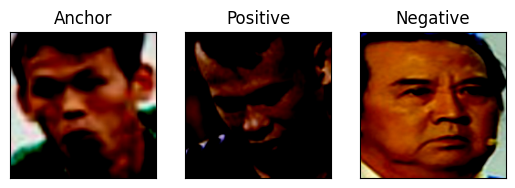

In [11]:
plot_triplet(triplet_train_face_dataset[10][0])

In [12]:
kwargs = {'num_workers': NUM_WORKERS, 'pin_memory': PIN_MEMORY} if cuda else {}

triplet_train_face_loader = torch.utils.data.DataLoader(triplet_train_face_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
triplet_test_face_loader = torch.utils.data.DataLoader(triplet_test_face_dataset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)


loss_fn = TripletLoss(margin)

optimizer = optim.Adam(facenet_model.parameters(), lr=learning_rate)
scheduler_linear = lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=LR_WARMUP)
scheduler_cosine = lr_scheduler.CosineAnnealingLR(optimizer, T_max=490, eta_min=learning_rate/100)
scheduler = lr_scheduler.SequentialLR(optimizer, [scheduler_linear,scheduler_cosine],milestones=[10])

In [13]:
# fit(train_loader = triplet_train_face_loader, 
#     val_loader=triplet_test_face_loader, 
#     model= facenet_model, 
#     loss_fn=loss_fn,
#     optimizer=optimizer, 
#     scheduler = scheduler, 
#     n_epochs=EPOCHS, 
#     device=device, 
#     log_interval=log_interval,)

In [14]:
# torch.save(facenet_model.state_dict(), "models/facenet_tune/facenet.pt")
torch.save(facenet_model, MODEL_DIR)

## Online Pair Selection

In [15]:
# train_face_dataset.targets

In [18]:
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_face_dataset, n_classes=3, n_samples=2, is_dataset=True)
test_batch_sampler = BalancedBatchSampler(test_face_dataset, n_classes=3, n_samples=2, is_dataset=True)

# sampler = BalancedBatchSampler(train_face_dataset, n_classes=n_classes, n_samples=n_samples)

# loader = DataLoader(train_face_dataset, batch_sampler=sampler, **kwargs)


kwargs = {'num_workers': NUM_WORKERS, 'pin_memory': PIN_MEMORY} if cuda else {}

online_train_loader = torch.utils.data.DataLoader(train_face_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_face_dataset, batch_sampler=test_batch_sampler, **kwargs)


loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
optimizer = optim.Adam(facenet_model.parameters(), lr=learning_rate)
scheduler_linear = lr_scheduler.LinearLR(optimizer, start_factor=0.01, total_iters=LR_WARMUP)
scheduler_cosine = lr_scheduler.CosineAnnealingLR(optimizer, T_max=490, eta_min=learning_rate/100)
scheduler = lr_scheduler.SequentialLR(optimizer, [scheduler_linear,scheduler_cosine],milestones=[10])


In [19]:

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from collections import Counter

# Assuming BalancedBatchSampler is already defined

# Parameters
n_classes = 2  # Number of classes per batch
n_samples = 3   # Number of samples per class
batch_size = n_classes * n_samples

# Create the balanced batch sampler
# sampler = BalancedBatchSampler(dataset, n_classes=n_classes, n_samples=n_samples)
sampler = BalancedBatchSampler(train_face_dataset, n_classes=n_classes, n_samples=n_samples, is_dataset=True)
loader = DataLoader(train_face_dataset, batch_sampler=sampler, **kwargs)

def check_batch_balance(batch_labels):
    label_counts = Counter(batch_labels.numpy())
    print(f"Batch size: {len(batch_labels)}")
    print(f"Unique classes in batch: {len(label_counts)}")
    print(f"Samples per class: {label_counts}")
    is_balanced = all(count == n_samples for count in label_counts.values())
    return is_balanced

# Check a few batches
for i, (_, labels) in enumerate(loader):
    print(f"\nBatch {i + 1}:")
    is_balanced = check_batch_balance(labels)
    print(f"Is batch balanced? {is_balanced}")
    
    if i == 4:  # Check 5 batches
        break

print("\nSampler length:", len(sampler))
print("Loader length:", len(loader))


Batch 1:
Batch size: 6
Unique classes in batch: 2
Samples per class: Counter({2: 3, 3: 3})
Is batch balanced? True

Batch 2:
Batch size: 5
Unique classes in batch: 2
Samples per class: Counter({2: 3, 0: 2})
Is batch balanced? False

Batch 3:
Batch size: 6
Unique classes in batch: 2
Samples per class: Counter({5: 3, 2: 3})
Is batch balanced? True

Batch 4:
Batch size: 6
Unique classes in batch: 2
Samples per class: Counter({1: 3, 2: 3})
Is batch balanced? True

Sampler length: 5
Loader length: 5


In [20]:
# Use facenet_embedding_net not the facenet_model
fit(train_loader = online_train_loader, 
                val_loader=online_test_loader, 
                model= facenet_embedding_net, 
                loss_fn=loss_fn,
                optimizer=optimizer, 
                scheduler = scheduler, 
                n_epochs=EPOCHS, 
                device=device, 
                log_interval=log_interval,)

d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/30 (0%)]	Loss: 0.993756
Epoch: 1/10. Train set: Average loss: 0.6909
Epoch: 1/10. Validation set: Average loss: 0.3746
Train: [0/30 (0%)]	Loss: 0.334164
Epoch: 2/10. Train set: Average loss: 0.3016
Epoch: 2/10. Validation set: Average loss: 0.4097
Train: [0/30 (0%)]	Loss: 0.075894
Epoch: 3/10. Train set: Average loss: 0.3186
Epoch: 3/10. Validation set: Average loss: 0.7280
Train: [0/30 (0%)]	Loss: 0.353510
Epoch: 4/10. Train set: Average loss: 0.7720
Epoch: 4/10. Validation set: Average loss: 0.9103
Train: [0/30 (0%)]	Loss: 0.373040
Epoch: 5/10. Train set: Average loss: 0.9653
Epoch: 5/10. Validation set: Average loss: 1.2019
Train: [0/30 (0%)]	Loss: 1.344984
Epoch: 6/10. Train set: Average loss: 0.8331
Epoch: 6/10. Validation set: Average loss: 0.4593
Train: [0/30 (0%)]	Loss: 1.022097
Epoch: 7/10. Train set: Average loss: 1.3997
Epoch: 7/10. Validation set: Average loss: 0.4959
Train: [0/30 (0%)]	Loss: 1.201862
Epoch: 8/10. Train set: Average loss: 0.9421
Epoch: 8/10. Valid

d:\Project\face-recogtion-mlops\.venv\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 10/10. Train set: Average loss: 0.5759
Epoch: 10/10. Validation set: Average loss: 0.5980


In [23]:
torch.save(facenet_embedding_net, MODEL_DIR)

# Inference

In [21]:
# facenet_model = torch.load("models/facenet_tune/facenet_2024_07_15_1.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.52156866].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid

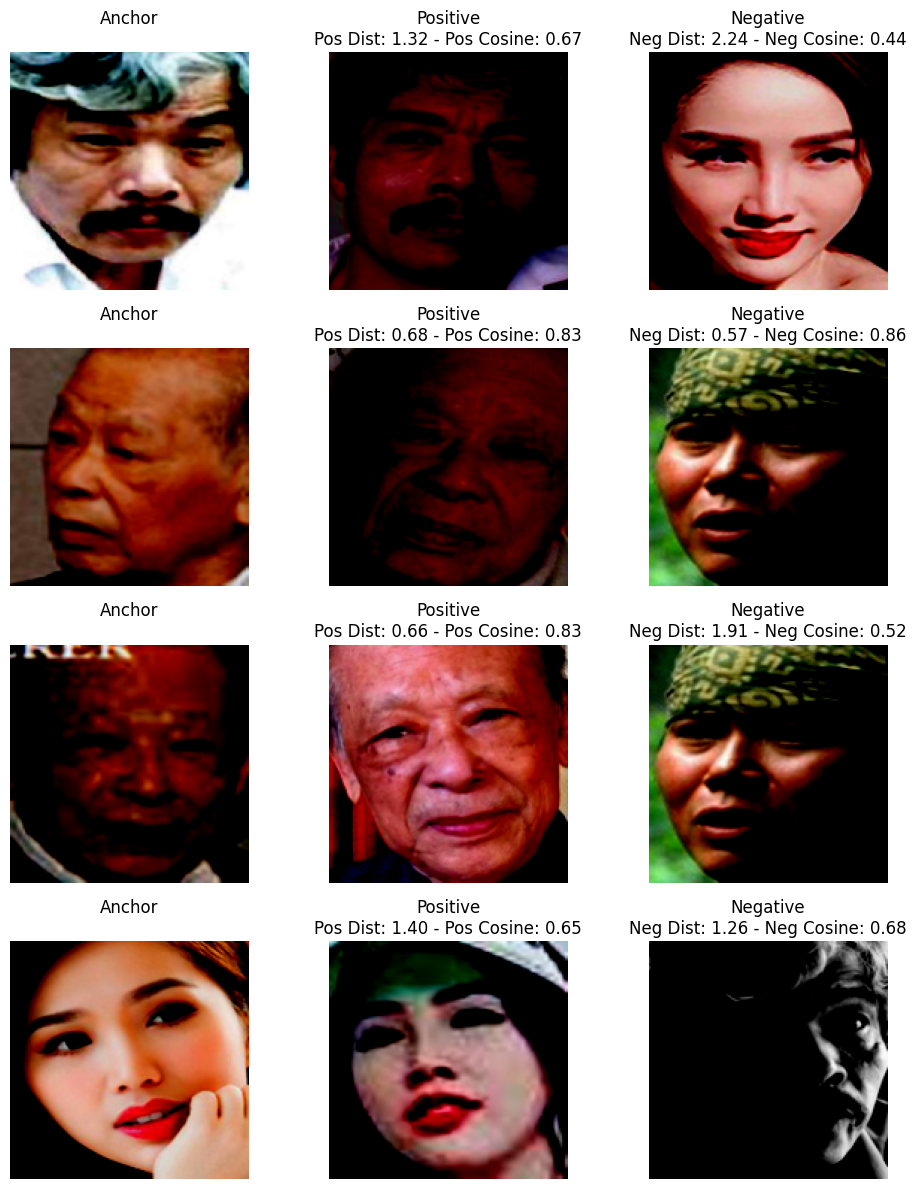

In [22]:
plot_model_result(facenet_model, triplet_train_face_loader, device)

In [26]:
facenet_embedding_net = torch.load("models/facenet_tune/facenet_2024_07_16_1.pth")
facenet_embedding_net = facenet_embedding_net.to(device)
facenet_model_2 = TripletNet(facenet_embedding_net)
facenet_model_2 = facenet_model.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9843137].
Clipping input data 

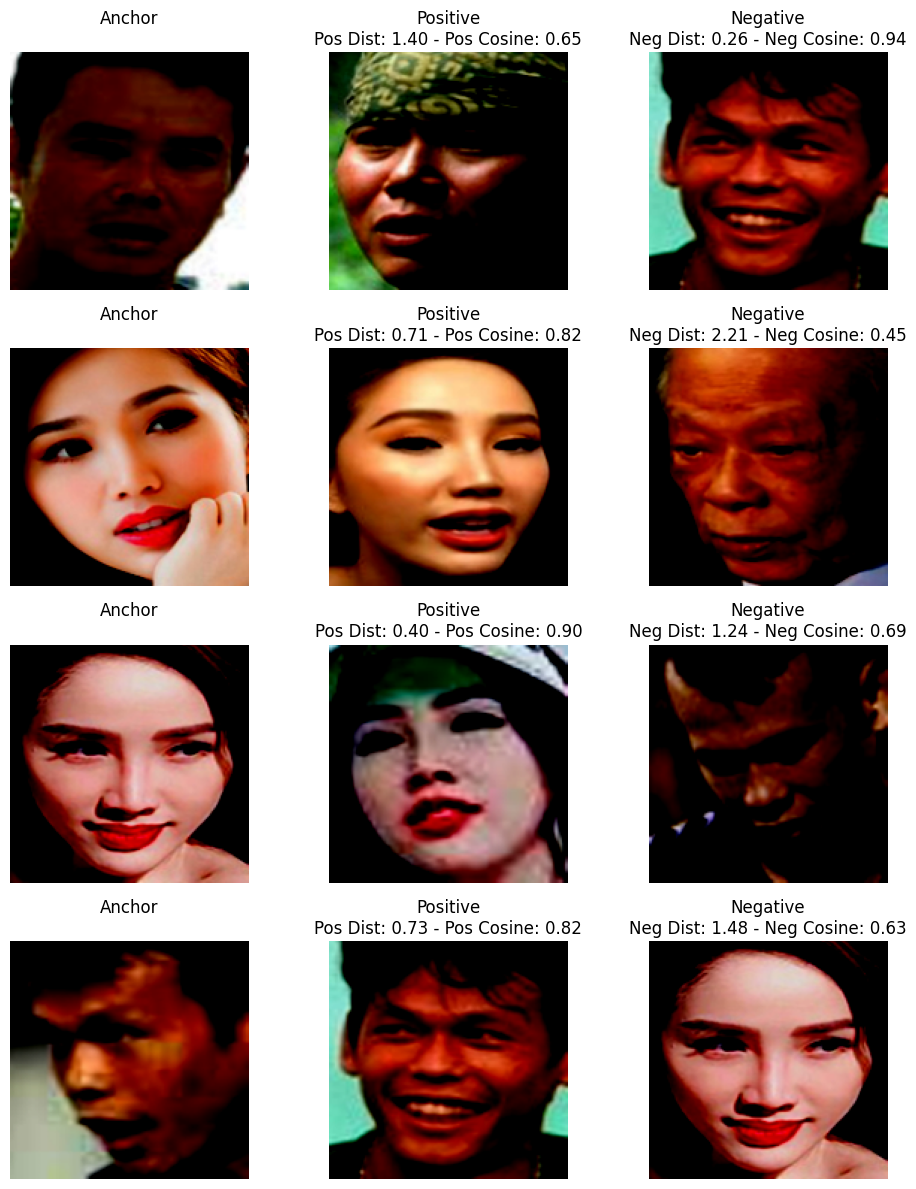

In [27]:
plot_model_result(facenet_model_2, triplet_train_face_loader, device)